<div style="text-align: center;">
    <h1><strong>Lord of the Rings Chatter</strong></h1>
    <div style="display: flex; justify-content: center;">
        <img src="lotr1.webp" alt="Image 1" style="width: 45%; margin: 0 2.5%;">
        <img src="lotr2.webp" alt="Image 2" style="width: 45%; margin: 0 2.5%;">
    </div>
</div>


Agent Assistant to Retrieve Data from Blog Web Pages.

In [5]:
import os
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain.schema import BaseMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_ollama import ChatOllama
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

DB = "db"
CHROMA_DB = "chroma_db"
EMBEDDING =  "sentence-transformers/multi-qa-mpnet-base-dot-v1"
LLAMA3 = "llama3"

load_dotenv()

True

## Index

In [6]:
current_dir = os.path.curdir
persistence_directory = os.path.join(current_dir, DB, CHROMA_DB)
embedding = HuggingFaceEmbeddings(model_name =EMBEDDING)

if not os.path.exists(persistence_directory):
    print("persistent directory does not exist, Initializing vector store...")

    urls = [
        "https://en.wikipedia.org/wiki/The_Lord_of_the_Rings",
        "https://en.wikipedia.org/wiki/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring",
        "http://lotr.fandom.com/wiki/The_Fellowship_of_the_Ring_(novel)"
    ]
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1500, chunk_overlap=300)
    doc_splits = text_splitter.split_documents(docs_list)

    db = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embedding,
        persist_directory=persistence_directory
    )
    
else:
    db = Chroma(persist_directory=persistence_directory, embedding_function=embedding, collection_name="rag-chroma")



retriever = db.as_retriever(search_type='similarity', search_kwargs={'k':5})

persistent directory does not exist, Initializing vector store...


## LLM

##### History Query Relevance Grader

In [7]:
llm_history_query_grader = ChatOllama(model=LLAMA3, temperature=0, format="json")

prompt_history_query_grader = PromptTemplate(
    template="""
        Given the current query or task, evaluate its relevance with respect to the historical context or previous interactions.
        query: {query}
        chat_history: {chat_history}

        Rules:
        - If `chat_history` is empty, classify as "unrelated" since there is no prior context.
        - If the query is independent and has no direct connection to the historical context, classify as "unrelated".
        - If the query builds upon or references the historical context, classify as "related".
        - If the relationship between the query and the historical context is unclear, classify as "ambiguous".
        - If the query is solely about recalling past conversations without introducing new topics, classify as "history_only".

        Return one of the following three possible outcomes, Provide a JSON with single key 'next_node' and fill it with what you choose, no premable or explanation:
        - "unrelated": If the current task or query is independent and has no direct connection to the historical context, or there is no chat history.
        - "related": If the current task or query is connected to or builds upon the historical context in some way.
        - "ambiguous": If the relationship between the current query and the historical context is unclear or cannot be determined with certaintyz
        - "history_only": If the query explicitly asks about past conversations without requesting new retrieval or analysis.

    """, input_variables=["query", "chat_history"]
)

history_query_grader = prompt_history_query_grader | llm_history_query_grader | JsonOutputParser()

##### History Only Responder

In [8]:
llm_history_responder = ChatOllama(model=LLAMA3, temperature=0)

prompt_history_responder = PromptTemplate(
    template="""
        The user is inquiring about past conversations they've had.
        query: {query}
        chat_history: {chat_history}

        Your task is to summarize the relevant past interactions clearly and concisely.
        Make sure the user feels acknowledged and that their past input is respected.
        Example responses:
        - "Previously, you mentioned that..."
        - "In our last conversation, you discussed..."
        - "You asked about X before, and here's what was covered..."

        Be polite and ensure the response is reflective of the user's past contributions.
    """, input_variables=["query", "chat_history"]
)

history_responder = prompt_history_responder | llm_history_responder | StrOutputParser()

#### Ambiguous responder

In [9]:
llm_ambiguous_responder = ChatOllama(model=LLAMA3, temperature=0)

prompt_ambiguous_responder = PromptTemplate(
    template="""
        The current query or task has been determined to have an ambiguous relationship with the historical context.
        query: {query}
        chat_history: {chat_history}
        As the "ambiguous_responder," provide a clear and helpful response to the user that acknowledges the ambiguity and offers guidance.
        The response should be polite and suggest next steps or clarifications to help resolve the uncertainty. For example:
        "It seems there’s some uncertainty about the relevance of this query to previous information. Could you please provide more context or clarify your request?"
        "I'm not entirely sure how this query relates to prior context. Can you help me understand the connection better?"
        "The relationship between the current task and previous data isn't fully clear. Can you give me more details?"
        Your goal is to help the user refine their query or provide further context, ensuring they feel supported despite the ambiguity.
    """, input_variables=["query"]
)

ambiguous_responder = prompt_ambiguous_responder | llm_ambiguous_responder | StrOutputParser()

##### Retriever Grader

In [10]:
llm_retriever_grader = ChatOllama(model=LLAMA3, temperature=0, format="json")

prompt_retriever_grader = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user query.
    Here is the retrieved document:{document}
    Here is the user query:{query}
    Assess whether the content of the document effectively addresses the user's intent and provides meaningful information related to the query. Consider factors such as:
    Does the document provide an answer, context, or information relevant to the query?
    Is the document's content aligned with the user's likely informational need, even if it doesn't contain exact keywords?
    Is the document generally useful for understanding or solving the user's problem as outlined in the query?
    Grade the relevance of the document using a binary score:
    'yes' if the document is relevant and answers or addresses the user query effectively.
    'no' if the document is irrelevant or does not meaningfully contribute to answering the user's query.
    Provide the binary score as a JSON response with a single key 'score' and no further explanation or preamble.
    """,
    input_variables=["query", "document"],
)

retriever_grader = prompt_retriever_grader | llm_retriever_grader | JsonOutputParser()

##### Query Re-writer

In [11]:
llm_query_rewriter = ChatOllama(model=LLAMA3, temperature=0)

prompt_query_rewriter = PromptTemplate(
    template="""
        You are a query re-writer tasked with improving the input query for better vectorstore retrieval performance.
        Your goal is to reformulate the query in a way that enhances its clarity, relevance, and retrieval accuracy, making it more suitable for the vector-based search system.
        Here is the original query: {query}
        Please provide an improved version of the query that is optimized for vectorstore retrieval, without any preamble or explanation.
    """,
    input_variables=["query"],
)

query_rewriter = prompt_query_rewriter | llm_query_rewriter | StrOutputParser()

##### Contextualizer

In [12]:
llm_contextualizer = ChatOllama(model=LLAMA3, temperature=0)

prompt_contextualizer_text = (
    "You are an AI that reformulates user queries based on chat history to make them standalone. "
    "Your task is to resolve references, pronouns, and vague descriptions using prior interactions. "
    "Ensure the reformulated question is clear, precise, and contains all necessary details for retrieval. "
    "If no relevant context exists in the chat history, return the question as is. "
    "Do NOT explain, introduce, or provide reasoning—just return the reformulated query with NO preamble."
)

prompt_contextualizer = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content=prompt_contextualizer_text),
        MessagesPlaceholder("chat_history"),
        ("human", "{query}")
    ]
)

contextualizer = prompt_contextualizer | llm_contextualizer | StrOutputParser()

##### Generater

In [13]:
llm_generator = ChatOllama(model=LLAMA3, temperature=0)

prompt_generator_text = """
    You are an assistant tasked with answering queries related to Lord of the Rings.
    Use the following pieces of context to formulate your response.

    If the answer is available in the context, provide a concise and clear response starting with:

    "Based on Lord of the Rings's documentation:" followed by your answer.
    If the answer is not found in the context, simply say:

    "I don't know."
    Always end your response with:

    "Ask me another question about Lord of the Rings!"
    Ensure your answer is concise, clear, and informative, without being overly brief.

    Context: {context}
"""

prompt_generator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompt_generator_text),
        MessagesPlaceholder("chat_history"),
        ("human", "{query}"),
    ]
)

generator = prompt_generator_prompt | llm_generator | StrOutputParser()

##### Hallucination Grader

In [14]:
llm_hallucination_grader = ChatOllama(model=LLAMA3, temperature=0, format="json")

hallucination_grader_prompt = PromptTemplate(
    template="""
        You are a grader tasked with assessing whether the provided answer is grounded in or supported by the given set of facts.

        Here are the facts: {documents}
        Here is the answer: {generation}

        Please provide a binary score:
        'yes' if the answer is supported by the facts.
        'no' if the answer is not supported by the facts.
        
        Return the score in JSON format with the key 'score', without any explanation or additional commentary.
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = hallucination_grader_prompt | llm_hallucination_grader | JsonOutputParser()

##### Answer Grader

In [15]:
llm_answer_grader = ChatOllama(model=LLAMA3, format="json", temperature=0)

answer_grader_prompt = PromptTemplate(
    template="""
        ou are a grader tasked with evaluating whether the provided answer is useful in resolving the given query.

        Here is the query: {query}
        Here is the answer:{generation}

        Please provide a binary score:
        'yes' if the answer is useful in resolving the question.
        'no' if the answer is not useful.
        
        Return the score in JSON format with the key 'score', without any explanation or additional commentary.
    """,
    input_variables=["generation", "query"],
)

answer_grader = answer_grader_prompt | llm_answer_grader | JsonOutputParser()

## Graph State

In [16]:
QUERY = "query"
GENERATION = "generation"
DOCUMENTS = "documents"
CHAT_HISTORY = "chat_history"
QUERY_TRANSFORMATION_ATTEMPTS = "query_transformation_attempts"
GENERATION_ATTEMPTS = "generation_attempts"


class GraphState(TypedDict):
    """
    Represent the state of the graph

    Attributes:
        query: query
        generation: LLM generation
        documents: list of documents
        chat_history: chat history
        attempts: number of attempts
    """

    query: str
    generation: str
    documents: List[str]
    chat_history: List[str]
    query_transformation_attempts: int
    generation_attempts: int

## Graph Details

### Nodes

#### History Relevant Check Node

In [17]:
def check_history_relevant(state):
    """
    Check history relevant

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Return query and chat_history
    """

    print("---CHECK CHAT HISTORY RELEVANT---")
    return state

#### Contextualize Node

In [18]:
def contextualize(state):
    """
    Contextualize query

    Args:
        state (dict): the current graph state
    Returns:
        state (dict): Update the query based on chat history
    """

    print("---CONTEXTUALIZE---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]

    contextualized_query = contextualizer.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )
    print(contextualized_query)
    state[QUERY] = contextualized_query
    return state

#### Retrieve Node

In [19]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    print("---RETRIEVE---")
    query = state[QUERY]

    documents = retriever.invoke(query)
    state[DOCUMENTS] = documents
    return state

#### Filterate Documents

In [20]:
def filterate_documents(state):
    """
    Fitlerate relveant documetns

    Args:
        state (dict): The current state graph
    Returns:
        state (dict): State with updaed documetns
    """
    print("---CHECK DOCUMENTS RELEVANCE TO QUERY")
    query = state[QUERY]
    documents = state[DOCUMENTS]

    filtered_docs = []
    for d in documents:
        score = retriever_grader.invoke(
            {
                QUERY: query,
                "document": d
            }
        )
        grade = score["score"]
        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    state[DOCUMENTS] = filtered_docs
    return state

#### History Only Responder

In [21]:
def history_only_respond(state):
    """
    Generate history only answer

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): new key added to state, that contains LLM generation for history only
    """

    print("---GENERATE HISTORY ONLY ANSWER---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]
    
    history_only_generation = history_responder.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )
    state[GENERATION] = history_only_generation
    return state

#### Ambiguous Responder Node

In [22]:
def ambiguous_respond(state):
    """
    Generate ambiguity anwer

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): new key added to state, that contains LLM generation for ambiguity
    """

    print("---GENERATE AMBIGUITY ANSWER---")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]
    
    ambiguity_generation = ambiguous_responder.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )
    state[GENERATION] = ambiguity_generation
    return state

#### Decrease Query Transformation Attemtps Node

In [23]:
def decrease_query_transformation_attempts(state):
    """
    Decrease the attempts of query transformation

    Args:
        state (dict): The current state
    Returns:
        state (dic): Increase the number of query_transformation_attempts
    """

    print(f'---DECREASE_{QUERY_TRANSFORMATION_ATTEMPTS}---')
    attempts = state[QUERY_TRANSFORMATION_ATTEMPTS]
    if attempts== 0:
        print(f'QUERY_TRANSFORMATION_ATTEMPTS: {attempts}')
        return state
    else:
        state[QUERY_TRANSFORMATION_ATTEMPTS]=attempts-1
        print(f'QUERY_TRANSFORMATION_ATTEMPTS: {attempts}')
        return state

#### Query Transformtion Attempts Checking Node

In [24]:
def check_query_transformation_attempts(state):
    """
    Check the number of query transformation attempts.

    Args:
        state (dict): The current state graph
    Returns:
        state (dict): The current state graph.
    """

    print("---CHECK_QUERY_TRANSFORAMTION_ATTEMPS_NUMBER---")
    return state

#### Transform Query Node

In [25]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current state
    Returns:
        state (dict): Updates query key with a re-phrased query
    """

    print("---TRANSFORM QUERY---")
    query = state[QUERY]

    better_query = query_rewriter.invoke({
        QUERY:query
    })

    state[QUERY] = better_query
    print("TRANSFORMED_QUERY: ", better_query)
    return state

#### Decrease Generation Attemtps Node

In [26]:
def decrease_generation_attempts(state):
    """
    Decrease the attempts of generation

    Args:
        state (dict): The current state
    Returns:
        state (dic): Increase the number of generation_attempts
    """

    print(f'---DECREASE_{GENERATION_ATTEMPTS}---')
    attempts = state[GENERATION_ATTEMPTS]
    if attempts == 0:
        print(f'GENERATION_ATTEMPTS: {attempts}')
        return state
    else:
        state[GENERATION_ATTEMPTS]= attempts - 1
        print(f'GENERATION_ATTEMPTS: {attempts}')
        return state

#### Generation Attempts Checking Node

In [27]:
def check_generation_attempts(state):
    """
    Check the number of generation attempts.

    Args:
        state (dict): The current state graph
    Returns:
        state (dict): The current state graph.
    """

    print("---CHECK_Generation_ATTEMPS_NUMBER---")
    return state

#### Generate Node

In [28]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): the current graph state
    Returns:
        state (dict): new key added to state, that contains LLM generation
    """

    print("---GENERATE---")
    query = state[QUERY]
    documents = state[DOCUMENTS]
    chat_history = state[CHAT_HISTORY]

    generation = generator.invoke(
        {
            "context": documents,
            CHAT_HISTORY: chat_history,
            "query": query
        }
    )
    state[GENERATION] = generation
    return state

#### Not Support Node

In [29]:
def get_not_support_state(state):
    """
    get not support state

    Args:
        state (dict): the current graph state
    Returns:
        state (dict): Not support state Data
    """

    print("---COULD NOT DO IT---")
    generation = "I could not do it, Please try again." #TODO need to Change

    state[GENERATION] = generation
    return state

### Edges

#### Decide Node to Call Based on History Relevance

In [30]:
def decide_node_to_call_based_on_history_relevancy(state):
    """
    Determines whether to move to 'Retrive', 'Contextualize" or Ambiguous'

    Args:
        state (dict): The current graph state
    Returns:
        'Retrive', 'Contextualize" or ambiguous' for next code to call
    """

    print("---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY")
    query = state[QUERY]
    chat_history = state[CHAT_HISTORY]

    grade = history_query_grader.invoke(
        {
            QUERY: query,
            CHAT_HISTORY: chat_history
        }
    )

    next_node = grade['next_node']
    if next_node == 'unrelated':
        print("---DECISION: QUERY IS NOT RELATED TO THE CHAT HISTORY---")
        return 'UNRELATED'
    elif next_node == 'related':
        print("---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---")
        return 'RELATED'
    elif next_node == 'ambiguous':
        print("---DECISION: QUERY IS AMBIGUOUS")
        return 'AMBIGUOUS'
    elif next_node == 'history_only':
        print("---DECISION: QUERY IS AMBIGUOUS")
        return 'HISTORY_ONLY'

#### Check Query Transfomration Attempts Number

In [31]:
def choose_next_call_based_on_query_transformation_attempts(state):
    """
    Check the number of query transformation attempts, if equal zero,
    and return the next node to call based on that.

    Args:
        state (dict): The current state graph
    Returns:
        Next node to call
    """

    print("---CHOOSE_NEXT_NODE_BASED_ON_QUERY_TRANSFORMATION_ATTEMPS---")
    if state[QUERY_TRANSFORMATION_ATTEMPTS] <= 0:
        return "NOT_SUPPORT_RESPOND_GENERATING"
    else:
        return "QUERY_TRANSFORMING"


#### Check Generation Attempts Number

In [32]:
def choose_next_call_based_on_generation_attempts(state):
    """
    Check the number of generation attempts, if equal zero,
    and return the next node to call based on that.

    Args:
        state (dict): The current state graph
    Returns:
        Next node to call
    """

    print("---CHOOSE_NEXT_NODE_BASED_ON_GENERATION_ATTEMPS---")
    if state[GENERATION_ATTEMPTS] <= 0:
        print("---DECISION: NOT_SUPPORT_RESPOND_GENERATING")
        return "NOT_SUPPORT_RESPOND_GENERATING"
    else:
        print("---DECISION: GENERATION")
        return "GENERATION"


#### Decide to Generate    

In [33]:
def decide_to_generate(state):
    """
    Determines whether to generate an asnwer, or re-write a query.

    Args:
        state (dict): The current graph state
    Returns:
        Binary decision for next node to call 
    """
        
    print("---ASSESS GRADED DOCUMENTS---")
    state[QUERY]
    filtered_docs = state[DOCUMENTS]

    if not filtered_docs:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUERY, DECREASE QT ATTEMPTS---")
        return "DECREASE_QT_ATTEMPTS"
    else:
        print("---DECISION: DECREASE GENERATION ATTEMPS---")
        return "DECREASE_GENERATION_ATTEMPS"


#### Grade Generation vs Documents and Query

In [34]:
def grade_generation_v_documents_and_query(state):
    """
    Determines whether the generation is frounded in the document and answers query.

    Args:
        state (dict): The current graph state
    Returns:
        Binary decision for next node to call
    """

    print("---CHECK HALLUCINATION---")
    query = state[QUERY]
    documents=state[DOCUMENTS]
    generation=state[GENERATION]

    score = hallucination_grader.invoke(
        {
            DOCUMENTS: documents,
            GENERATION: generation
        }
    )

    grade = score["score"]

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION VS QUERY")
        score = answer_grader.invoke(
            {
                GENERATION:generation,
                QUERY:query
            }
        )
        grade = score["score"]
        if grade == "yes":
            print("DECISION: GENERATION ADDRESSES QUERY---")
            return "USEFUL"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUERY---")
            return "NOT_USEFUL"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "NOT_USEFUL"


## Graph Core

In [35]:
workflow = StateGraph(GraphState)

workflow.add_node("HISTORY_RELEVANT_CHECKING", check_history_relevant)
workflow.add_node("HISTORY_ONLY_GENERATING", history_only_respond)
workflow.add_node("AMBIGUOUS_RESPOND_GENERATING", ambiguous_respond)
workflow.add_node("CONTEXTUALIZING", contextualize)
workflow.add_node("RETRIEVING", retrieve)
workflow.add_node("DOCUMENTS_FILTERATING", filterate_documents)
workflow.add_node("DECREASE_QT_ATTEMPTS", decrease_query_transformation_attempts)
workflow.add_node("QT_ATTEMPTS_CHECKING", check_query_transformation_attempts)
workflow.add_node("DECREASE_GENERATION_ATTEMPS", decrease_generation_attempts)
workflow.add_node("GENERATION_ATTEMPTS_CHECKING", check_generation_attempts)
workflow.add_node("GENERATION", generate)
workflow.add_node("QUERY_TRANSFORMING", transform_query)
workflow.add_node("NOT_SUPPORT_RESPOND_GENERATING", get_not_support_state)

workflow.add_edge(START, "HISTORY_RELEVANT_CHECKING")
workflow.add_conditional_edges(
    "HISTORY_RELEVANT_CHECKING",
    decide_node_to_call_based_on_history_relevancy,
    {
        "UNRELATED": "RETRIEVING",
        "RELATED": "CONTEXTUALIZING",
        "AMBIGUOUS": "AMBIGUOUS_RESPOND_GENERATING",
        "HISTORY_ONLY": "HISTORY_ONLY_GENERATING"
    }
)


workflow.add_edge("HISTORY_ONLY_GENERATING", END)
workflow.add_edge("AMBIGUOUS_RESPOND_GENERATING", END)

workflow.add_edge("CONTEXTUALIZING", "RETRIEVING")
workflow.add_edge("RETRIEVING", "DOCUMENTS_FILTERATING")

workflow.add_conditional_edges(
    "DOCUMENTS_FILTERATING",
    decide_to_generate,
    {
        "DECREASE_QT_ATTEMPTS": "DECREASE_QT_ATTEMPTS",
        "DECREASE_GENERATION_ATTEMPS" : "DECREASE_GENERATION_ATTEMPS"
    }
)
workflow.add_edge("DECREASE_QT_ATTEMPTS", "QT_ATTEMPTS_CHECKING")
workflow.add_conditional_edges(
    "QT_ATTEMPTS_CHECKING",
    choose_next_call_based_on_query_transformation_attempts,
    {
        "QUERY_TRANSFORMING": "QUERY_TRANSFORMING",
        "NOT_SUPPORT_RESPOND_GENERATING": "NOT_SUPPORT_RESPOND_GENERATING"
    }     
)

workflow.add_edge("QUERY_TRANSFORMING", "RETRIEVING")
workflow.add_edge("DECREASE_GENERATION_ATTEMPS", "GENERATION_ATTEMPTS_CHECKING")
workflow.add_conditional_edges(
    "GENERATION_ATTEMPTS_CHECKING",
    choose_next_call_based_on_generation_attempts,
    {
        "NOT_SUPPORT_RESPOND_GENERATING":"NOT_SUPPORT_RESPOND_GENERATING",
        "GENERATION":"GENERATION"
    }
)

workflow.add_edge("NOT_SUPPORT_RESPOND_GENERATING", END)


workflow.add_conditional_edges(
    "GENERATION",
    grade_generation_v_documents_and_query,
    {
        "USEFUL":END,
        "NOT_USEFUL": "DECREASE_GENERATION_ATTEMPS"
    }
)

app = workflow.compile()

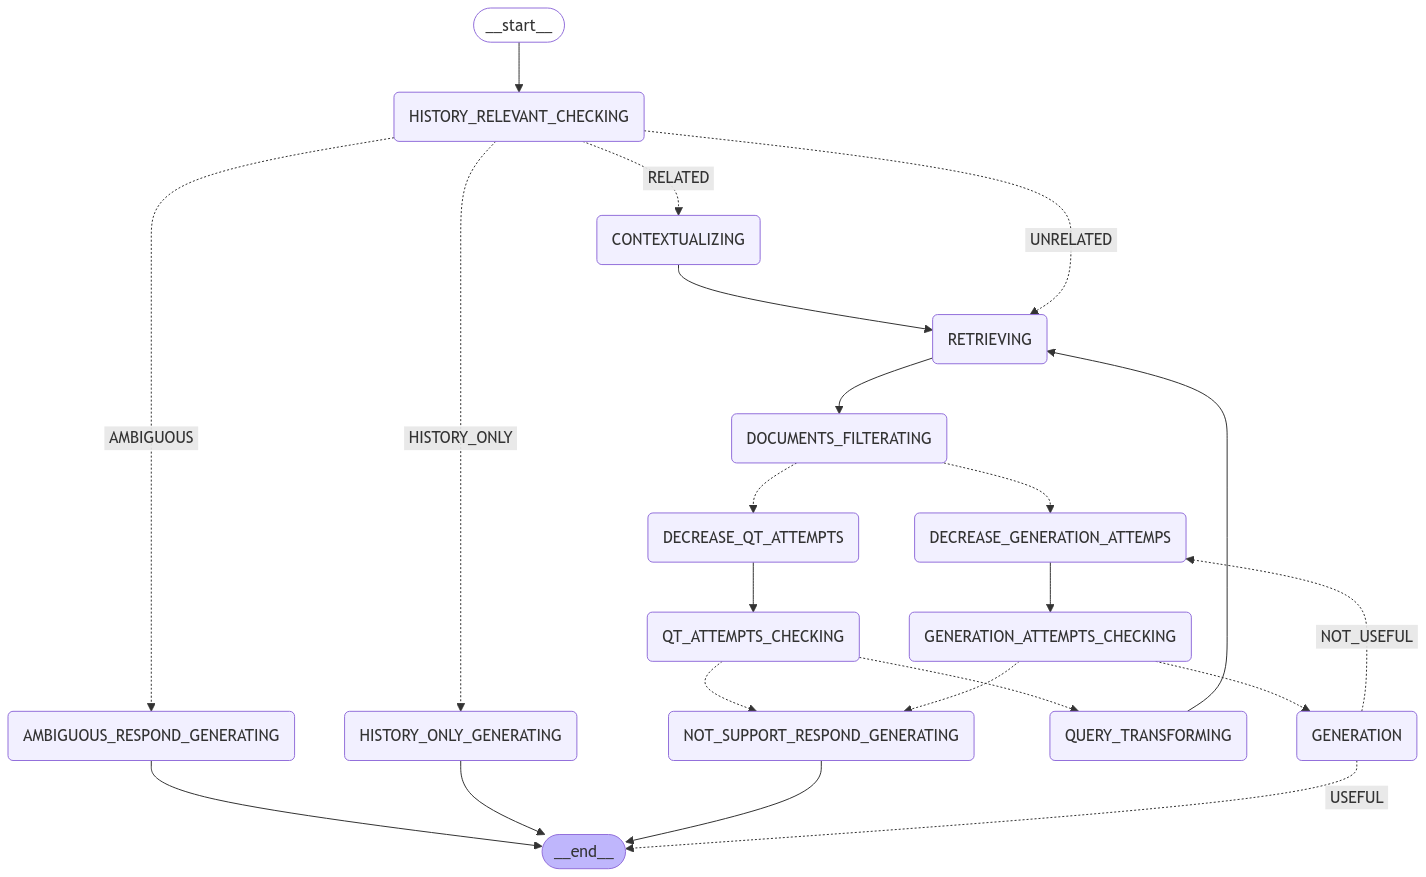

In [36]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Testing

In [37]:
from pprint import pprint
chat_history: BaseMessage = []

inputs = {
    QUERY : "What is Lord of the Rings?",
    CHAT_HISTORY: chat_history,
    GENERATION_ATTEMPTS: 3,
    QUERY_TRANSFORMATION_ATTEMPTS: 3
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}:")
    pprint("\n---\n")
    
chat_history.append(HumanMessage(content=f'{value[QUERY]}'))
chat_history.append(AIMessage(content=f'{value[GENERATION]}'))

pprint(value[GENERATION])

---CHECK CHAT HISTORY RELEVANT---
---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY
---DECISION: QUERY IS NOT RELATED TO THE CHAT HISTORY---
"Node 'HISTORY_RELEVANT_CHECKING:"
'\n---\n'
---RETRIEVE---
"Node 'RETRIEVING:"
'\n---\n'
---CHECK DOCUMENTS RELEVANCE TO QUERY
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DECREASE GENERATION ATTEMPS---
"Node 'DOCUMENTS_FILTERATING:"
'\n---\n'
---DECREASE_generation_attempts---
GENERATION_ATTEMPTS: 3
"Node 'DECREASE_GENERATION_ATTEMPS:"
'\n---\n'
---CHECK_Generation_ATTEMPS_NUMBER---
---CHOOSE_NEXT_NODE_BASED_ON_GENERATION_ATTEMPS---
---DECISION: GENERATION
"Node 'GENERATION_ATTEMPTS_CHECKING:"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION VS QUERY
DECISION: GENERATION ADDRESSES QUERY---
"Node 'GENERATION:"
'\n---\n

In [38]:
inputs = {
    QUERY : "who is the white wizard?",
    CHAT_HISTORY: chat_history,
    GENERATION_ATTEMPTS: 3,
    QUERY_TRANSFORMATION_ATTEMPTS: 3
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}:")
    pprint("\n---\n")
    
chat_history.append(HumanMessage(content=f'{value[QUERY]}'))
chat_history.append(AIMessage(content=f'{value[GENERATION]}'))

pprint(value[GENERATION])

---CHECK CHAT HISTORY RELEVANT---
---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY
---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---
"Node 'HISTORY_RELEVANT_CHECKING:"
'\n---\n'
---CONTEXTUALIZE---
Gandalf the Grey!
"Node 'CONTEXTUALIZING:"
'\n---\n'
---RETRIEVE---
"Node 'RETRIEVING:"
'\n---\n'
---CHECK DOCUMENTS RELEVANCE TO QUERY
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DECREASE GENERATION ATTEMPS---
"Node 'DOCUMENTS_FILTERATING:"
'\n---\n'
---DECREASE_generation_attempts---
GENERATION_ATTEMPTS: 3
"Node 'DECREASE_GENERATION_ATTEMPS:"
'\n---\n'
---CHECK_Generation_ATTEMPS_NUMBER---
---CHOOSE_NEXT_NODE_BASED_ON_GENERATION_ATTEMPS---
---DECISION: GENERATION
"Node 'GENERATION_ATTEMPTS_CHECKING:"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION VS Q

In [39]:
inputs = {
    QUERY : "explain to me why the fellowship choose moria way",
    CHAT_HISTORY: chat_history,
    GENERATION_ATTEMPTS: 3,
    QUERY_TRANSFORMATION_ATTEMPTS: 3
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}:")
    pprint("\n---\n")
    
chat_history.append(HumanMessage(content=f'{value[QUERY]}'))
chat_history.append(AIMessage(content=f'{value[GENERATION]}'))

pprint(value[GENERATION])

---CHECK CHAT HISTORY RELEVANT---
---CHOOSE NEXT NODE TO CALL BASED ON HISTORY RELEVANCY
---DECISION: QUERY IS RELATED TO THE CHAT HISTORY---
"Node 'HISTORY_RELEVANT_CHECKING:"
'\n---\n'
---CONTEXTUALIZE---
The Fellowship of the Ring chose Moria as their route because they were trying to reach the eastern side of the Misty Mountains, which would allow them to avoid the perilous passes and valleys controlled by Sauron's forces.

Gandalf had previously explored Moria and knew that it was a treacherous place, but he believed that the Fellowship could navigate its dangers and make their way through to the other side. He also hoped to find some clues or information about the location of the One Ring in Moria, as it was said to be an ancient stronghold of the dwarves.

Additionally, Gandalf wanted to test the Fellowship's resolve and unity by taking them through a challenging and potentially deadly environment. He believed that if they could survive the perils of Moria, they would be better 